In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re 
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from gensim.models import Word2Vec

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import hamming_loss

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding,Input, Dense, Dropout, BatchNormalization,GlobalAveragePooling1D
from tensorflow.keras.layers import LSTM,Bidirectional,RNN,LSTMCell
from tensorflow.keras.initializers import Constant
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

In [5]:
train_data=pd.read_csv('C:/train.csv')
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
test_data=pd.read_csv('C:/test.csv',engine='python')
test_data.head()

,id,comment_text
0,0001ea8717f6de06,Thank you for understanding. I think very high...
1,000247e83dcc1211,:Dear god this site is horrible.
2,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig..."
3,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ..."
4,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l..."


# Label Count

C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


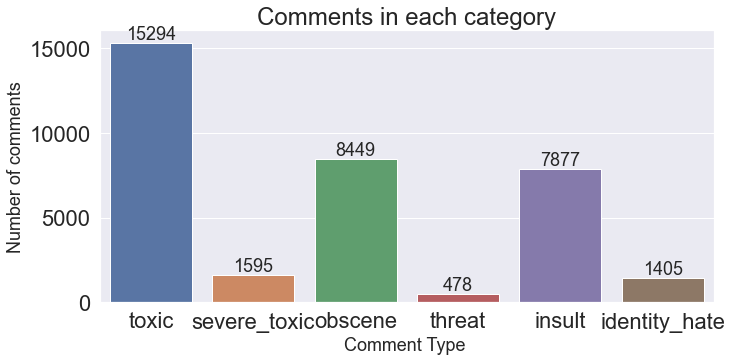

In [7]:
categories = list(train_data.drop(['id','comment_text'],axis=1).columns.values)
sns.set(font_scale = 2)
plt.figure(figsize=(11,5))
ax= sns.barplot(categories,train_data.iloc[:,2:].sum().values)
plt.title("Comments in each category", fontsize=24)
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Comment Type ', fontsize=18)
#adding the text labels
rects = ax.patches
labels = train_data.iloc[:,2:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)
plt.show()

# Comments having multiple labels

C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


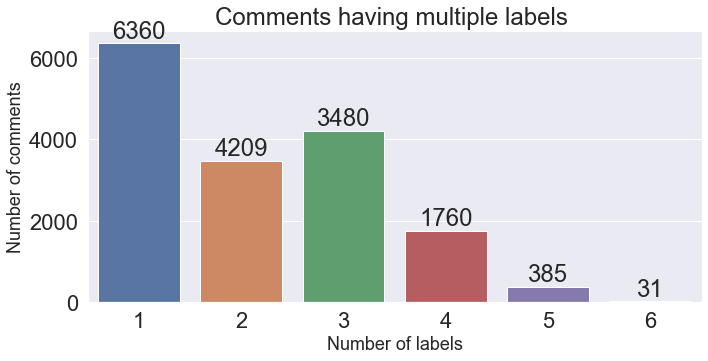

In [8]:
rowSums = train_data.iloc[:,2:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[1:]
sns.set(font_scale = 2)
plt.figure(figsize=(11,5))
ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)
plt.title("Comments having multiple labels ")
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Number of labels', fontsize=18)
#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

# Text Preprocessing

In [9]:
# defing stopwords manually
STOP_WORDS= set([ 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't",'utc'])


# initializzing for lemmatizing
wnl = WordNetLemmatizer()

# function for text cleaning
def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    x = re.sub("\S*\d\S*", "", str(x)).strip()
    x = re.sub('[^A-Za-z0-9]+', ' ', str(x))
    #Stop word removal and Applying WordNetLemmatizer
    x = ' '.join(wnl.lemmatize(w) for w in x.split() if w not in STOP_WORDS)
  
    return x


In [10]:
# Applying the function for text cleaning
train_data['cleaned_comment']=train_data['comment_text'].apply(preprocess)

# text before pre-processing

In [11]:
train_data['comment_text'].values[1]

"D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"

# text after pre-processing

In [12]:
train_data['cleaned_comment'].values[1]

'aww match background colour seemingly stuck thanks talk january'

# Word cloud for the most used words in comments

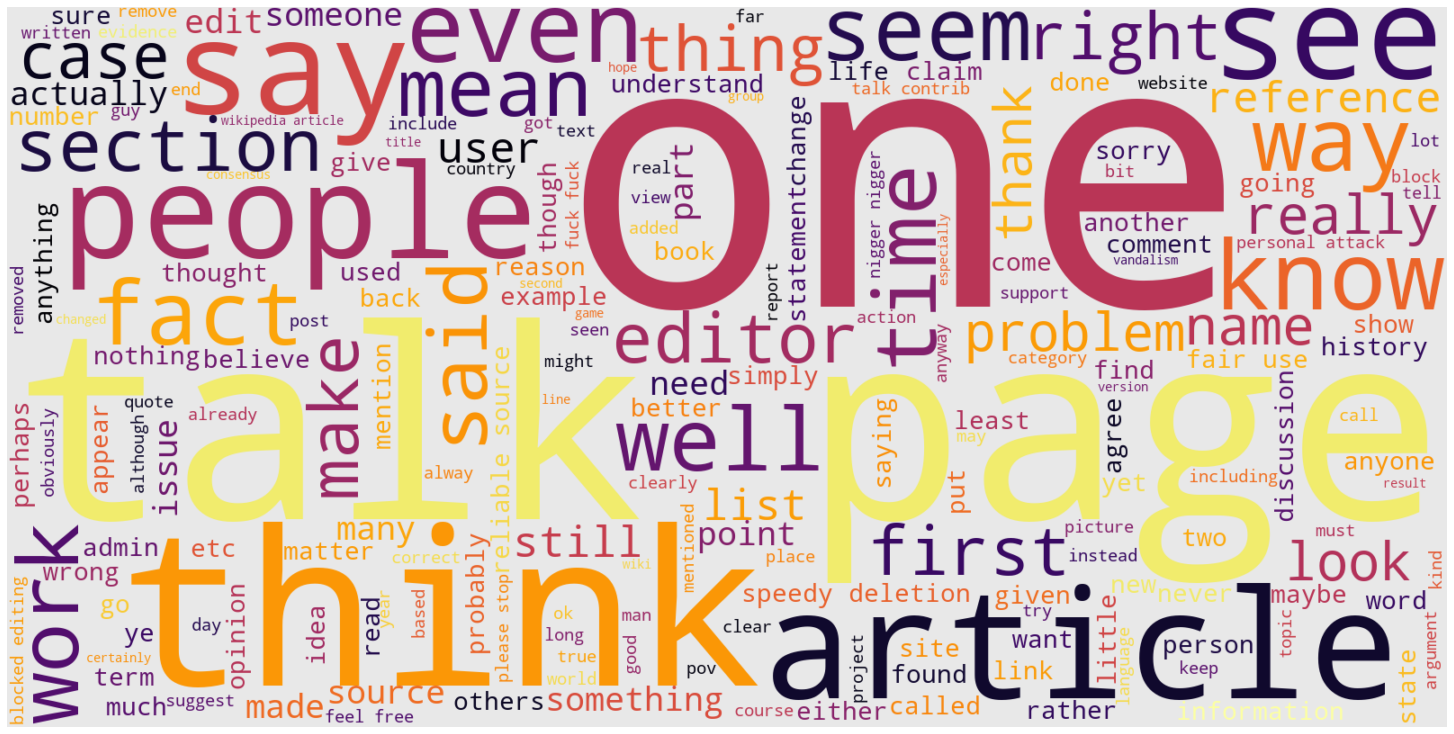

In [13]:
%matplotlib inline

Text=train_data.cleaned_comment.str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800, background_color="#E8E8E8",colormap="inferno_r", min_font_size = 10).generate(Text) 
%matplotlib inline
# plot the WordCloud image                        
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear') 

plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 
  

In [13]:
token_comment=[nltk.word_tokenize(comment) for comment in train_data['cleaned_comment']]

In [14]:
token_comment[:2]

[['explanation',
  'edits',
  'made',
  'username',
  'hardcore',
  'metallica',
  'fan',
  'reverted',
  'not',
  'vandalism',
  'closure',
  'gas',
  'voted',
  'new',
  'york',
  'doll',
  'fac',
  'please',
  'not',
  'remove',
  'template',
  'talk',
  'page',
  'since',
  'retired'],
 ['aww',
  'match',
  'background',
  'colour',
  'seemingly',
  'stuck',
  'thanks',
  'talk',
  'january']]

# getting word embeddings using Word2vec

In [15]:
embedding_dim=200


In [ ]:
word_vec=Word2Vec(sentences=token_comment,size=embedding_dim,workers=4,min_count=1)

In [ ]:
words=list(word_vec.wv.vocab)

In [18]:
print('Vocabulary size:',len(words))

Vocabulary size: 153095


# testing our trained word2vec

In [19]:
word_vec.wv.most_similar('horrible')

[('ruined', 0.7926034927368164),
 ('crazy', 0.7427648305892944),
 ('terrible', 0.7371752262115479),
 ('obsessed', 0.7360952496528625),
 ('ashamed', 0.7342053651809692),
 ('idiotic', 0.7235391736030579),
 ('dumbshit', 0.7222187519073486),
 ('ugly', 0.71854168176651),
 ('pretentious', 0.6990963220596313),
 ('nasty', 0.6932998895645142)]

In [20]:
vec = word_vec.wv['king']-word_vec.wv['man']+word_vec.wv['woman']

In [21]:
word_vec.most_similar([vec])

C:\Users\ASUS\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('emperor', 0.7395616769790649),
 ('australain', 0.7225110530853271),
 ('king', 0.7201218605041504),
 ('prince', 0.7176343202590942),
 ('norman', 0.717232346534729),
 ('royal', 0.7047961354255676),
 ('father', 0.7030995488166809),
 ('bidatsu', 0.6978943347930908),
 ('monk', 0.6977564692497253),
 ('bishop', 0.697190523147583)]

In [22]:
# Save the built word2vec model
word_vec.wv.save_word2vec_format('wordvec3.txt',binary=False)

# Transforming the data into format required for models and getting word embeddings

In [16]:
# Extract word embeddings from the saved word2vec model
embeddings_index={}
f=open(os.path.join('','wordvec3.txt'),encoding='utf-8')
for line in f:
    values=line.split()
    word=values[0]
    coefs=np.asarray(values[1:])
    embeddings_index[word]=coefs
f.close()

In [17]:
# tokenzing the sequences
tokenizer_obj=Tokenizer()  
tokenizer_obj.fit_on_texts(token_comment)
sequences = tokenizer_obj.texts_to_sequences(token_comment)



In [18]:
# Max length of sequence
def FindMaxLength(lst): 
    maxList = max(lst, key = lambda i: len(i)) 
    maxLength = len(maxList) 
      
    return maxLength 
# Driver Code 
lst = sequences
print('Max length:',FindMaxLength(lst))

Max length: 1250


In [19]:
max_length=1250

In [20]:
#pad sequences to the max length
word_index = tokenizer_obj.word_index
print('Found %s unique tokens'% len(word_index))
comment_pad=pad_sequences(sequences,maxlen=max_length)

Found 153095 unique tokens


In [21]:
# Creating an embedding matrix

In [22]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,embedding_dim))
for word,i in word_index.items():
    if i>num_words:
        continue
    embedding_vector=embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i]=embedding_vector

# Splitting the data into train and validation

In [23]:
X_train,X_test,Y_train,Y_test=train_test_split(comment_pad,train_data[['toxic','severe_toxic','obscene','threat','insult','identity_hate']],test_size=0.20,random_state=42)

In [24]:
X_train.shape

(127656, 1250)

In [25]:
Y_train.shape

(127656, 6)

In [26]:
Y_train=np.array(Y_train)

In [27]:
Y_test=np.array(Y_test)

In [28]:
Y_train.shape

(127656, 6)

# Defining callback function

In [29]:
# Stops when validation accuracy reaches 98%
class myCB(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if(logs.get('val_accuracy') is not None and logs.get('val_accuracy') >0.98): 
            print('\nReached least val_loss')
            self.model.stop_training = True


In [30]:
cb = myCB()

# Building Bi-Directional Lstm model

# Using sigmoid as activation and binary crossentropy as loss because it is multilabel classification

In [31]:
model = Sequential()
model.add(Embedding(num_words,
              embedding_dim,
              input_length = max_length,
              weights = [embedding_matrix],
              trainable = False,mask_zero=True))
model.add(Bidirectional(LSTM(64,return_sequences=False)))
model.add(Dropout(0.2))
model.add(Dense(50, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(25, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation = 'sigmoid'))
model.summary()
model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate=0.0001), metrics = ['accuracy'])
history = model.fit(X_train, Y_train, epochs = 10,batch_size=64, verbose = 2, validation_data=(X_test,Y_test),callbacks=[cb])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1250, 200)         30619200  
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               135680    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                6450      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                1275      
_________________________________________________________________
dropout_2 (Dropout)          (None, 25)                0

# So we reached a test subset accuracy of 98%. Limited the accuracy in callback because  my GPU (4GB) was taking a lot of time for each epoch

In [52]:
model.save('toxic_comment_proj.h5')

In [29]:
model=load_model('toxic_comment_proj.h5')

# Predicting the values for New Data

In [30]:
# Cleaning the data
test_data['cleaned_comment']=test_data['comment_text'].apply(preprocess)

In [31]:
# Converting it into format to pass
pred_token_comment=[nltk.word_tokenize(comment) for comment in test_data['cleaned_comment']]

In [32]:
# Getting tokens using the previous built tokenizer
sequences_pred = tokenizer_obj.texts_to_sequences(pred_token_comment)

#padding 
comment_pad_New=pad_sequences(sequences_pred,maxlen=max_length)

In [33]:
# Predicting 
predicted_values=model.predict(comment_pad_New)

In [34]:
# making a new column with predicted values as a list
test_data['vals']=predicted_values.tolist()

In [35]:
# Creating new empty columns
test_data[['toxic','severe_toxic','obscene','threat','insult','identity_hate']]=np.nan

In [36]:
# Code for assigning added cols values from the vals column
for i in range(test_data.shape[0]):
    li=test_data.vals[i]
    test_data.toxic[i]=li[0]
    test_data.severe_toxic[i]=li[1]
    test_data.obscene[i]=li[2]
    test_data.threat[i]=li[3]
    test_data.insult[i]=li[4]
    test_data.identity_hate[i]=li[5]

C:\Users\ASUS\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\ASUS\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\ASUS\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\ASUS\anaconda3\lib\site-packages\ipykernel_launc

In [48]:
test_data.head()

,id,comment_text,cleaned_comment,vals,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0001ea8717f6de06,Thank you for understanding. I think very high...,thank understanding think highly would not rev...,"[8.95751581992954e-05, 5.106376192998141e-07, ...",0.000090,5.106376e-07,0.000026,1.090430e-06,0.000026,3.104504e-06
1,000247e83dcc1211,:Dear god this site is horrible.,dear god site horrible,"[0.246911883354187, 0.0021065601613372564, 0.0...",0.246912,2.106560e-03,0.033123,2.749251e-03,0.052962,6.896953e-03
2,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",somebody invariably try add religion really me...,"[0.02642667293548584, 0.0001796879223547876, 0...",0.026427,1.796879e-04,0.003887,3.303558e-04,0.004762,1.074759e-03
3,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",say right type type institution needed case th...,"[5.188087379792705e-05, 5.744884035152609e-08,...",0.000052,5.744884e-08,0.000005,1.532748e-07,0.000007,5.124158e-07
4,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",adding new product list make sure relevant add...,"[2.3597132894792594e-05, 2.6958311138969293e-0...",0.000024,2.695831e-08,0.000004,8.391297e-08,0.000004,3.857169e-07


In [49]:
test_data.drop(columns=['comment_text','cleaned_comment','vals'],axis=1,inplace=True)

In [50]:
#0.5 is the cut-off
test_data.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0001ea8717f6de06,0.000090,5.106376e-07,0.000026,1.090430e-06,0.000026,3.104504e-06
1,000247e83dcc1211,0.246912,2.106560e-03,0.033123,2.749251e-03,0.052962,6.896953e-03
2,0002f87b16116a7f,0.026427,1.796879e-04,0.003887,3.303558e-04,0.004762,1.074759e-03
3,0003e1cccfd5a40a,0.000052,5.744884e-08,0.000005,1.532748e-07,0.000007,5.124158e-07
4,00059ace3e3e9a53,0.000024,2.695831e-08,0.000004,8.391297e-08,0.000004,3.857169e-07


In [51]:
# Making a csv file for the above data frame
test_data.to_csv('toxic_comment_predictions.csv')